In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, mean_absolute_error
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

import pickle

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../feature_selection/data/embdedding_features.csv', index_col=0)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,percent_nClick,BinNclick
0,3.396450,0.401957,2.514440,-1.278493,0.696468,0.669427,1.454799,-1.411128,-2.325530,-0.340336,...,2.123550,-2.131998,3.520958,5.353183,0.080014,-1.365481,0.852700,-0.551261,0.0,0.0
1,2.752378,2.324396,2.828439,-3.433444,0.401047,-2.011863,-0.728933,-2.993193,-3.696246,1.775527,...,2.362711,-4.364689,4.750610,5.487312,0.432480,-3.199559,-0.086040,-0.206128,0.0,0.0
2,3.490490,1.512165,3.403857,-3.632755,0.310504,-1.970605,-0.608910,-4.947670,-4.198528,2.167250,...,3.768230,-4.947408,6.480114,6.462525,0.973213,-2.188324,-0.684284,0.239616,0.0,0.0
3,2.533500,-0.790464,3.620891,-2.186726,0.025617,0.246850,0.983440,-3.700051,-3.112433,1.624841,...,1.038836,-3.782856,4.963671,6.902436,-0.580284,-1.205756,0.094856,-0.153280,0.0,0.0
4,1.848037,1.126874,3.977530,-4.518314,-0.000538,-2.603749,-1.701738,-5.130782,-4.403915,3.763445,...,1.359940,-6.128437,5.913571,7.023829,-0.172708,-3.132971,-0.755029,0.065173,0.0,0.0


Text(0.5, 1.0, 'Распределение таргетов')

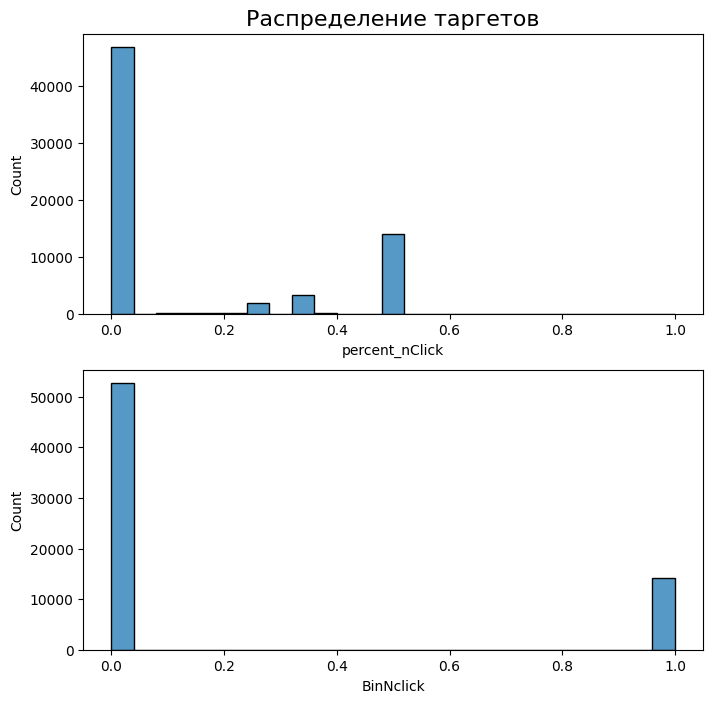

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.histplot(
    data=df,
    x='percent_nClick',
    bins=25,
    #kde=True,
    ax=axes[0]
);
sns.histplot(
    data=df,
    x='BinNclick',
    bins=25,
    ax=axes[1]
);
axes[0].set_title('Распределение таргетов', fontsize=16)

## Регрессия

In [4]:
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['percent_nClick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### LightGBM

In [6]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbosity':-1,
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=100)

[I 2024-05-19 22:38:41,398] A new study created in memory with name: no-name-e55180b7-c6fe-4b9d-9eba-70211594be82
[I 2024-05-19 22:38:43,373] Trial 0 finished with value: 0.04291081397950139 and parameters: {'lambda_l2': 0.862551564287668, 'max_depth': 78, 'num_leaves': 25, 'learning_rate': 0.621, 'bagging_fraction': 0.6}. Best is trial 0 with value: 0.04291081397950139.
[I 2024-05-19 22:38:44,588] Trial 1 finished with value: 0.04057590324096541 and parameters: {'lambda_l2': 0.8344982425273492, 'max_depth': 24, 'num_leaves': 25, 'learning_rate': 0.41100000000000003, 'bagging_fraction': 0.8}. Best is trial 1 with value: 0.04057590324096541.
[I 2024-05-19 22:38:46,645] Trial 2 finished with value: 0.03956979724220291 and parameters: {'lambda_l2': 0.7720423371157853, 'max_depth': 86, 'num_leaves': 45, 'learning_rate': 0.101, 'bagging_fraction': 0.6}. Best is trial 2 with value: 0.03956979724220291.
[I 2024-05-19 22:38:47,812] Trial 3 finished with value: 0.03997672657937007 and parameter

C:\Users\smart\AppData\Local\Temp\ipykernel_24344\1341559625.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

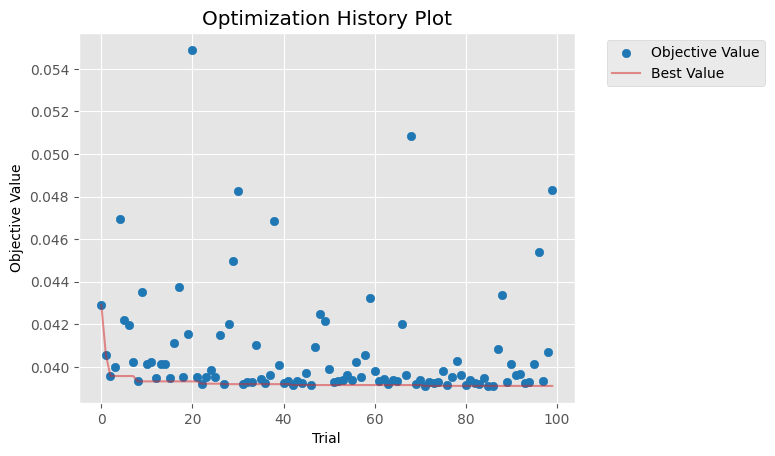

In [7]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_reg)

In [8]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.03910431742885541
  Параметры: 
    lambda_l2: 0.3698677252928434
    max_depth: 77
    num_leaves: 105
    learning_rate: 0.101
    bagging_fraction: 0.7


In [9]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test)

# Считаем основные метрики
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
#mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"MSE LightGBM: {round(mse_lgbm, 3)}")
#print(f"MAE LightGBM: {round(mae_lgbm, 3)}")
print(f"R2_score LightGBM: {round(r2_lgbm, 3)*100}%")

MSE LightGBM: 0.039
R2_score LightGBM: 7.6%


In [10]:
# Сохраним модель
with open(r'models/lgb_reg_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)

### CatBoost

In [11]:
def objective_catb_reg(trial):
    # Подбираемые параметры
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучаем модель
    optuna_model = CatBoostRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_catb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_catb_reg.optimize(objective_catb_reg, n_trials=100)

[I 2024-05-19 22:43:02,610] A new study created in memory with name: no-name-b64fe3de-b3e2-4a3f-8357-addb1d05236e
[I 2024-05-19 22:43:16,985] Trial 0 finished with value: 0.04048237008025761 and parameters: {'iterations': 893, 'learning_rate': 0.010518580788308578, 'depth': 4, 'l2_leaf_reg': 0.5258289545844843, 'random_strength': 3.178855785150376e-07, 'bagging_temperature': 9.982107117485114, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 0 with value: 0.04048237008025761.
[I 2024-05-19 22:43:22,216] Trial 1 finished with value: 0.0418343109337735 and parameters: {'iterations': 252, 'learning_rate': 0.001301497640404344, 'depth': 4, 'l2_leaf_reg': 0.00030462804263543553, 'random_strength': 6.417030680446511e-07, 'bagging_temperature': 8.904652115696104, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 0 with value: 0.04048237008025761.
[I 2024-05-19 22:44:38,477] Trial 2 finished with value: 0.04041233874173353 and parameters: {'iterations': 670, 'learning_rate': 0.0043246549536

C:\Users\smart\AppData\Local\Temp\ipykernel_24344\1089751886.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

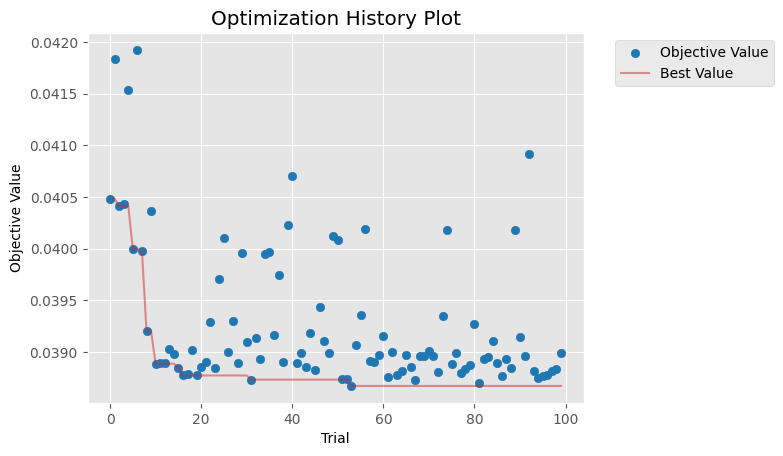

In [12]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_catb_reg)

In [13]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_reg.trials)))
print('Лучший трайл:')
trial = study_catb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.03867285789578638
  Параметры: 
    iterations: 785
    learning_rate: 0.049562656868153254
    depth: 10
    l2_leaf_reg: 3.023628789677935e-06
    random_strength: 0.00015977320250296488
    bagging_temperature: 0.4110244937973404
    od_type: IncToDec
    od_wait: 16


In [14]:
# Обучим модель на получившихся параметрах
params = trial.params
catb_reg = CatBoostRegressor(verbose=0,**params)
catb_reg.fit(X_train, y_train)

# Предсказание
y_pred_catb_reg = catb_reg.predict(X_test)

# Считаем основные метрики
mse_catb = mean_squared_error(y_test, y_pred_catb_reg)
r2_catb = r2_score(y_test, y_pred_catb_reg)

# Выводим основные метрики
print(f"MSE CatBoost: {round(mse_catb, 3)}")
print(f"R2_score CatBoost: {round(r2_catb, 3)*100}%")

MSE CatBoost: 0.039
R2_score CatBoost: 8.7%


In [15]:
# Сохраним модель
with open(r'models/catb_reg_model.pkl', 'wb') as file:
    pickle.dump(catb_reg, file)

### XGBoost

In [ ]:
def objective_xgb_reg(trial):
    # Подбираемые параметры
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучаем модель
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_xgb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_xgb_reg.optimize(objective_xgb_reg, n_trials=100)

In [ ]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_xgb_reg)

In [ ]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_reg.trials)))
print('Лучший трайл:')
trial = study_xgb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# Обучим модель на получившихся параметрах
params = trial.params
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

# Предсказание
y_pred_xgb_reg = xgb_reg.predict(X_test)

# Считаем основные метрики
mse_xgb = mean_squared_error(y_test, y_pred_xgb_reg)
r2_xgb = r2_score(y_test, y_pred_xgb_reg)

# Выводим основные метрики
print(f"MSE XGBoost: {round(mse_xgb, 3)}")
print(f"R2_score XGBoost: {round(r2_xgb, 3)*100}%")

In [ ]:
# Сохраним модель
with open(r'models/xgb_reg_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

## Классификация

In [17]:
# Выделяем таргет
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['BinNclick']

# Разделяем данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Посмотрим распределение меток по данным
print(f'Распределение в обучающих данных: {y_train.value_counts()}')
print(f'Распределение в тестовых данных: {y_test.value_counts()}')

Распределение в обучающих данных: BinNclick
0.0    42056
1.0    11431
Name: count, dtype: int64
Распределение в тестовых данных: BinNclick
0.0    10648
1.0     2724
Name: count, dtype: int64


In [18]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### LightGBM

In [ ]:
def objective_lgbm_class(trial):
    """Определение целевой функции для LightGBM Classification"""
    
    # Задаем сетку параметров
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "depth": trial.suggest_int("depth", 4, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "force_col_wise": True,
        'verbose': -1,
    }

    # Обучение модели
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_lgbm_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_lgbm_class.optimize(objective_lgbm_class, n_trials=100)

In [ ]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_class)

In [ ]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_class.trials)))
print('Лучший трайл:')
trial = study_lgbm_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [19]:
with open("models/lgbm_class_model.pkl", "rb") as f:
    lgbm_class = pickle.load(f)

In [20]:
# Обучим модель на получившихся параметрах
# params = trial.params
# lgbm_class = LGBMClassifier(verbose=-1,**params)
# lgbm_class.fit(X_train, y_train)

# Предсказание
y_pred_lgbm_class = lgbm_class.predict(X_test)
f1_lgbm = f1_score(y_test, y_pred_lgbm_class)

# Выводим основные метрики
print(f"F1-score LightGBM: {round(f1_lgbm, 3)}")
print('Classification report LightGBM:')
print(classification_report(y_test, y_pred_lgbm_class))

F1-score LightGBM: 0.256
Classification report LightGBM:
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88     10648
         1.0       0.52      0.17      0.26      2724

    accuracy                           0.80     13372
   macro avg       0.67      0.56      0.57     13372
weighted avg       0.76      0.80      0.76     13372



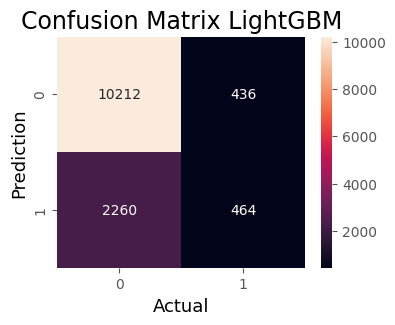

In [21]:
# Посмотрим на матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm_class)
sns.heatmap(con_mat_lgbm,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix LightGBM', fontsize=17)
plt.show()

In [ ]:
# Сохраним модель
with open(r'models/lgb_class_model.pkl', 'wb') as file:
    pickle.dump(lgbm_class, file)

### CatBoost

In [ ]:
def objective_catb_class(trial):
    """Определение целевой функции для CatBoost Classification"""

    # Подбираемые параметры
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучение модели
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_catb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_catb_class.optimize(objective_catb_class, n_trials=100)

In [ ]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_catb_class)

In [ ]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_class.trials)))
print('Лучший трайл:')
trial = study_catb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [22]:
with open("models/catb_class_model.pkl", "rb") as f:
    catb_class = pickle.load(f)

In [23]:
# Обучим модель с полученными параметрами
# params = trial.params
# catb_class = CatBoostClassifier(verbose=0,**params)
# catb_class.fit(X_train, y_train)

# Предсказание
y_pred_catb_class = catb_class.predict(X_test)
f1_catb = f1_score(y_test, y_pred_catb_class)

# Посмотрим на основные метрики качества
print(f"F1-score CatBoost: {round(f1_catb, 3)}")
print('Classification report CatBoost:')
print(classification_report(y_test, y_pred_catb_class))

F1-score CatBoost: 0.254
Classification report CatBoost:
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     10648
         1.0       0.47      0.17      0.25      2724

    accuracy                           0.79     13372
   macro avg       0.65      0.56      0.57     13372
weighted avg       0.75      0.79      0.75     13372



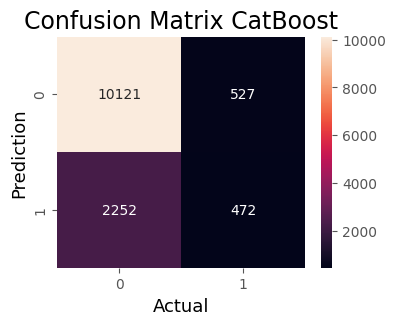

In [24]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_catb = confusion_matrix(y_test, y_pred_catb_class)
sns.heatmap(con_mat_catb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix CatBoost', fontsize=17)
plt.show()

In [ ]:
# Сохраним полученную модель
with open(r'models/catb_class_model.pkl', 'wb') as file:
    pickle.dump(catb_class, file)

### XGBoost

In [ ]:
def objective_xgb_class(trial):
    """Определение целевой функции для XGBoost Classification"""

    # Подбираемые параметры
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучение модели
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_xgb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_xgb_class.optimize(objective_xgb_class, n_trials=100)

In [ ]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_xgb_class)

In [ ]:
#plot_param_importances(study_xgb_class)

In [ ]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_class.trials)))
print('Лучший трайл:')
trial = study_xgb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [25]:
with open("models/xgb_class_model.pkl", "rb") as f:
    xgb_class = pickle.load(f)

In [26]:
# Обучим модель с полученными параметрами
# params = trial.params
# xgb_class = XGBClassifier(**params)
# xgb_class.fit(X_train, y_train)

# Предсказание
y_pred_xgb_class = xgb_class.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb_class)

# Посмотрим на основные метрики качества
print(f"F1-score XGBoost: {round(f1_xgb, 3)}")
print('Classification report XGBoost:')
print(classification_report(y_test, y_pred_xgb_class))

F1-score XGBoost: 0.307
Classification report XGBoost:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85     10648
         1.0       0.35      0.27      0.31      2724

    accuracy                           0.75     13372
   macro avg       0.59      0.57      0.58     13372
weighted avg       0.73      0.75      0.74     13372



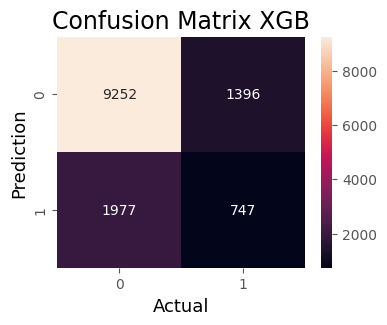

In [27]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_xgb = confusion_matrix(y_test, y_pred_xgb_class)
sns.heatmap(con_mat_xgb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix XGB', fontsize=17)
plt.show()

In [ ]:
# Сохраним полученную модель
with open(r'models/xgb_class_model.pkl', 'wb') as file:
    pickle.dump(xgb_class, file)

In [ ]:
# sns.set_color_codes("muted")

# plt.figure(figsize=(6, 6))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
# lw = 2
# plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
# plt.plot([0, 1], [0, 1])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# #plt.savefig("ROC.png")
# plt.show()